# Tratamiento de `outliers`

**Autor:** Jazna Meza Hidalgo

**Correo Electrónico:** ja.meza@profesor.duoc.cl

**Fecha de Creación:** Octubre de 2025  
**Versión:** 1.0

---

## Descripción

Este notebook contiene la explicación del tratamiento de valores atípicos en un set de datos. Se genera un conjunto de datos artificial que contienen valores atípicos y se aplica la técnica.

Además, se incorpora el uso de `pipeline`


---

## Requisitos de Software

Este notebook fue desarrollado con Python 3.12. A continuación se listan las bibliotecas necesarias:

- pandas (>=1.1.0)
- numpy (1.26.4)
- matplotlib (3.7.1)
- seaborn (0.13.1)

Para verificar la versión instalada ejecutar usando el siguiente comando, usando la librería de la cual quieres saber la versión:

```python
import pandas as pd
print(pd.__version__)
````

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
class Winsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, limits=(0.05, 0.05)):
        self.limits = limits

    def fit(self, X, y=None):
        # Guardar nombres si es DataFrame, si no generar nombres genéricos
        if isinstance(X, pd.DataFrame):
            self.columns_ = X.columns
        else:
            self.columns_ = np.arange(X.shape[1])
        return self

    def transform(self, X):
        X = pd.DataFrame(X, columns=self.columns_)
        for col in self.columns_:
            lower = X[col].quantile(self.limits[0])
            upper = X[col].quantile(1 - self.limits[1])
            X[col] = np.clip(X[col], lower, upper)
        return X.values

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return np.array(self.columns_)
        else:
            return np.array(input_features)

# Explicación

---
`Constructor __init__(self, limits=(0.05, 0.05))`

`limits` define cuánta cola se recorta en cada lado. (0.05, 0.05) significa: recortar (winsorizar) el 5% inferior y el 5% superior.

---
`fit(self, X, y=None)`

Guarda los nombres de columnas si X es un DataFrame: self.columns_.

Esto permite mantener los nombres y devolver el mismo esquema de columnas en transform.

---
`transform(self, X)`

Convierte X en DataFrame usando self.columns_.

Para cada columna calcula lower = quantile(limits[0]) y upper = quantile(1 - limits[1]).

Reemplaza los valores por debajo de lower con lower y los valores por encima de upper con upper (usa np.clip o pd.Series.clip).

Devuelve un np.array (X.values) — importante: al devolver un array, el siguiente paso del pipeline (por ejemplo StandardScaler) recibe un array sin nombres. Por eso el transformer implementa get_feature_names_out para poder recuperar nombres.

---
`get_feature_names_out(self, input_features=None)`

Permite que `ColumnTransformer` obtenga los nombres de salida. Si se le pasan `input_features` devuelve éstas; si no, devuelve self.columns_.

---

**winsorización** implica limitar valores extremos a percentiles razonables (no se borran, se acotan).Es menos agresivo que eliminar filas y menos arbitrario que reemplazar por mediana.

# ¿Por qué usarlo en un `pipeline`?

+ **Consistencia en entrenamiento/inferencia:** el `pipeline.fit` aprende parámetros (p. ej. percentiles en fit), y `pipeline.predict` aplica exactamente las mismas transformaciones a nuevos datos. Esto evita fugas y discrepancias.

+ **Reproducibilidad y orden:** se encapsula preprocesamiento y modelo en un solo objeto.

+ **Evita warnings** cuando se hacen las predicciones con datos sin transformar.

# Generación de dataset sintético con `outliers`



Se genera un conjunto de datos sintético de un tamaño suficiente para apreciar el efecto de los `outliers`

Serán 5 variables independientes y la dependiente con algo de *ruido*.

In [3]:
np.random.seed(29)
n = 6000

X = pd.DataFrame({
    "x1": np.random.normal(0, 1, n),
    "x2": np.random.normal(5, 2, n),
    "x3": np.random.normal(-2, 1.5, n),
    "x4": np.random.normal(10, 3, n),
    "x5": np.random.normal(0, 1, n)
})

# Relación lineal verdadera + ruido
true_coefs = np.array([3.0, -1.5, 2.0, 0.5, -2.5])
y = X.values.dot(true_coefs) + np.random.normal(scale=2.0, size=n)

# Agregar los `outliers`

In [4]:
n_outliers = int(0.01 * n)
idx_out = np.random.choice(n, size=n_outliers, replace=False)
for i, col in enumerate(X.columns):
    inds = np.random.choice(idx_out, size=int(n_outliers/2), replace=False)
    X.loc[inds, col] = X.loc[inds, col] * (20 + i*5)  # factores crecientes

print("Dataset creado con outliers visibles:")
display(X.describe().T)

Dataset creado con outliers visibles:


,count,mean,std,min,25%,50%,75%,max
x1,6000.0,0.029511,1.826223,-39.756056,-0.662319,0.018138,0.703151,44.331216
x2,6000.0,5.694498,10.542671,-2.336044,3.640561,5.023667,6.391847,246.588079
x3,6000.0,-2.305136,5.554901,-185.258536,-3.017707,-2.005484,-1.003280,5.196634
x4,6000.0,11.787986,25.656167,-0.498156,7.973740,10.049931,12.116857,599.320683
x5,6000.0,0.005141,2.505744,-88.603478,-0.665353,0.006893,0.669522,48.476231


# Separación de la data en entrenamiento y prueba

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=29)

# Ejemplo visual: distribución de x1 antes y después de winsorizar

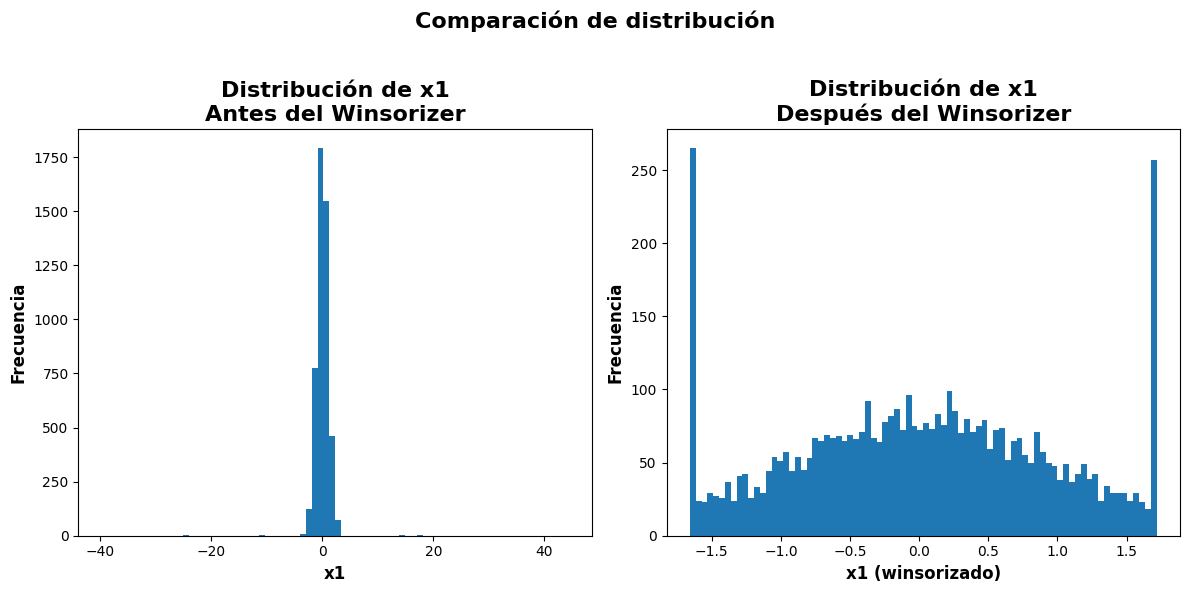

In [26]:
wins = Winsorizer(limits=(0.05, 0.05))
wins.fit(X_train)
X_train_wins = pd.DataFrame(wins.transform(X_train), columns=X_train.columns)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("Comparación de distribución", fontsize=16, fontweight="bold")
axes[0].hist(X_train["x1"], bins=80)
axes[0].set_title("Distribución de x1\nAntes del Winsorizer", fontsize=16, fontweight="bold")
axes[0].set_xlabel("x1", fontsize=12, fontweight="bold")
axes[0].set_ylabel("Frecuencia", fontsize=12, fontweight="bold")

axes[1].hist(X_train_wins["x1"], bins=80)
axes[1].set_title("Distribución de x1\nDespués del Winsorizer", fontsize=16, fontweight="bold")
axes[1].set_xlabel("x1 (winsorizado)", fontsize=12, fontweight="bold");
axes[1].set_ylabel("Frecuencia", fontsize=12, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Creación de Pipelines: con y sin Winsorizer

In [7]:
features_num = X.columns.tolist()

# Pipeline numérico con Winsorizer
numeric_with = Pipeline(steps=[
    ("winsorizer", Winsorizer(limits=(0.05, 0.05))),
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

# Pipeline numérico sin Winsorizer
numeric_without = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

# ColumnTransformers
pre_with = ColumnTransformer([("num", numeric_with, features_num)])
pre_without = ColumnTransformer([("num", numeric_without, features_num)])

# Pipelines completos
pipe_with = Pipeline([
    ("preprocessor", pre_with),
    ("regressor", LinearRegression())
])

pipe_without = Pipeline([
    ("preprocessor", pre_without),
    ("regressor", LinearRegression())
])

# Entrenamiento y evaluación

In [15]:
pipe_with.fit(X_train, y_train)
pipe_without.fit(X_train, y_train)

y_pred_with = pipe_with.predict(X_test)
y_pred_without = pipe_without.predict(X_test)

mse_with = mean_squared_error(y_test, y_pred_with)
mse_without = mean_squared_error(y_test, y_pred_without)
r2_with = r2_score(y_test, y_pred_with)
r2_without = r2_score(y_test, y_pred_without)

print(f"\nMétricas en test:")
print(f"\tCon Winsorizer -> MSE: {mse_with:.4f} | R2: {r2_with:.4f}")
print(f"\tSin Winsorizer -> MSE: {mse_without:.4f} | R2: {r2_without:.4f}")


Métricas en test:
	Con Winsorizer -> MSE: 5.6922 | R2: 0.8608
	Sin Winsorizer -> MSE: 35.0121 | R2: 0.1440


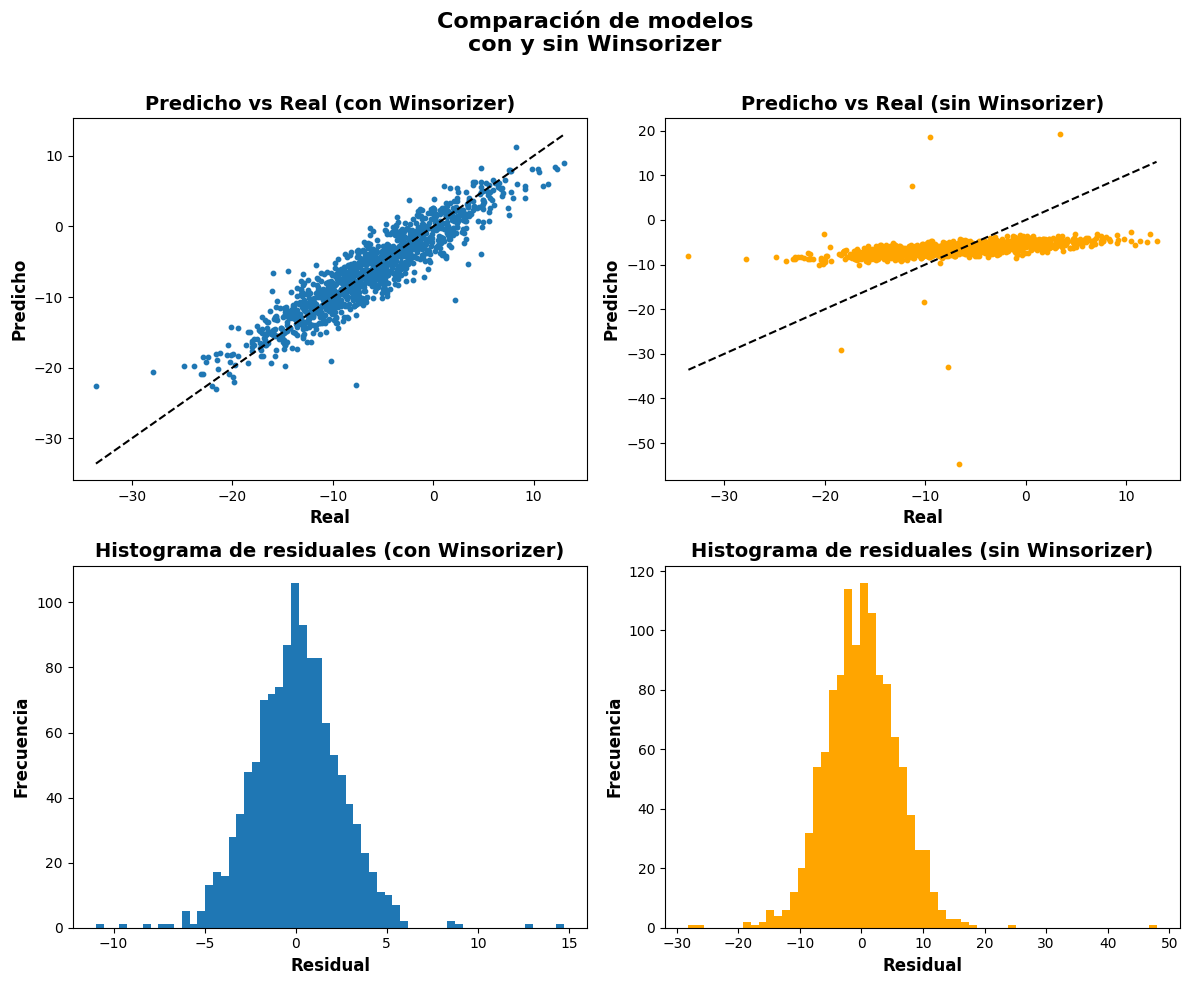

In [14]:
# Análisis de residuales
resid_with = y_test - y_pred_with
resid_without = y_test - y_pred_without

# Visualización conjunta: matriz 2x2
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Comparación de modelos\ncon y sin Winsorizer", fontsize=16, fontweight="bold")

# --- Fila 1: Predicho vs Real ---
axes[0, 0].scatter(y_test, y_pred_with, s=10)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
axes[0, 0].set_title("Predicho vs Real (con Winsorizer)", fontsize=14, fontweight="bold")
axes[0, 0].set_xlabel("Real", fontsize=12, fontweight="bold")
axes[0, 0].set_ylabel("Predicho", fontsize=12, fontweight="bold")

axes[0, 1].scatter(y_test, y_pred_without, s=10, color='orange')
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
axes[0, 1].set_title("Predicho vs Real (sin Winsorizer)", fontsize=14, fontweight="bold")
axes[0, 1].set_xlabel("Real", fontsize=12, fontweight="bold")
axes[0, 1].set_ylabel("Predicho", fontsize=12, fontweight="bold")

# --- Fila 2: Histogramas de residuales ---
axes[1, 0].hist(resid_with, bins=60)
axes[1, 0].set_title("Histograma de residuales (con Winsorizer)", fontsize=14, fontweight="bold")
axes[1, 0].set_xlabel("Residual", fontsize=12, fontweight="bold")
axes[1, 0].set_ylabel("Frecuencia", fontsize=12, fontweight="bold")

axes[1, 1].hist(resid_without, bins=60, color='orange')
axes[1, 1].set_title("Histograma de residuales (sin Winsorizer)", fontsize=14, fontweight="bold")
axes[1, 1].set_xlabel("Residual", fontsize=12, fontweight="bold")
axes[1, 1].set_ylabel("Frecuencia", fontsize=12, fontweight="bold")

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()
